In [6]:
mode = "svg"

import matplotlib

font = {'family' : 'Dejavu Sans',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

import matplotlib
from matplotlib import pyplot as plt

import warnings; warnings.filterwarnings("ignore")

In [7]:
from graspologic.simulations import sbm
import numpy as np
from graphbook_code import dcsbm, generate_dcsbm_pmtx, \
                           generate_sbm_pmtx

n = 150  # the number of nodes
# human brains have homophilic block structure
Bhum = np.array([[0.2, 0.02], [0.02, 0.2]])
# alien brains add degree-correction
theta_alien = np.tile(np.linspace(1.5, 0.5, n // 2), 2)

# generate human and alien brain network
np.random.seed(0)
A_human, z = sbm([n // 2, n // 2], Bhum, return_labels=True)
A_alien = dcsbm(z, theta_alien, Bhum)

Phum = generate_sbm_pmtx(z, Bhum)
Palien = generate_dcsbm_pmtx(z, theta_alien, Bhum)

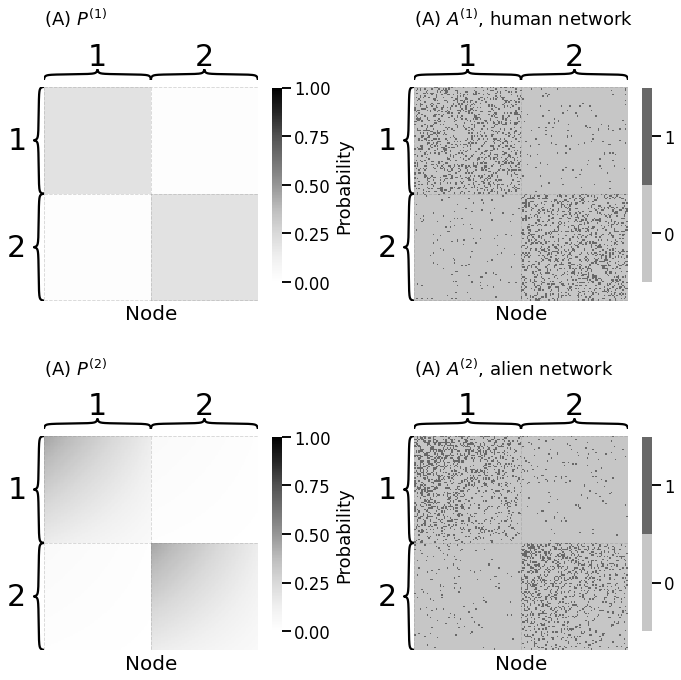

In [8]:
from graphbook_code import heatmap
import os
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

heatmap(Phum, legend_title="Probability", ax=axs[0][0],
       xtitle="Node", inner_hier_labels=z + 1, vmin=0, vmax=1,
       title="(A) $P^{(1)}$")
heatmap(A_human.astype(int), ax=axs[0][1],
       xtitle="Node", inner_hier_labels=z + 1, vmin=0, vmax=1,
       title="(A) $A^{(1)}$, human network")

heatmap(Palien, legend_title="Probability", ax=axs[1][0],
       xtitle="Node", inner_hier_labels=z + 1, vmin=0, vmax=1,
       title="(A) $P^{(2)}$")
heatmap(A_alien.astype(int), ax=axs[1][1],
       xtitle="Node", inner_hier_labels=z + 1, vmin=0, vmax=1,
       title="(A) $A^{(2)}$, alien network")

fig.tight_layout()

fname = "ts_ex"
os.makedirs("Figures", exist_ok=True)
if mode != "png":
    os.makedirs(f"Figures/{mode:s}", exist_ok=True)
    fig.savefig(f"Figures/{mode:s}/{fname:s}.{mode:s}")

os.makedirs("Figures/png", exist_ok=True)
fig.savefig(f"Figures/png/{fname:s}.png")

In [9]:
from scipy.linalg import orthogonal_procrustes
from graspologic.embed import AdjacencySpectralEmbed as ase

d = 2
# estimate latent positions for alien and human networks
Xhat_human = ase(n_components=d).fit_transform(A_human)
Xhat_alien = ase(n_components=d).fit_transform(A_alien)
# estimate best possible rotation of Xhat_alien to Xhat_human by 
# solving orthogonal procrustes problem
W = orthogonal_procrustes(Xhat_alien, Xhat_human)[0]
observed_norm = np.linalg.norm(Xhat_human - Xhat_alien @ W, ord="fro")

In [10]:
from graspologic.simulations import rdpg

def generate_synthetic_networks(X):
    """
    A function which generates two synthetic networks with
    same latent position matrix X.
    """
    A1 = rdpg(X, directed=False, loops=False)
    A2 = rdpg(X, directed=False, loops=False)
    return A1, A2

Ap, App = generate_synthetic_networks(Xhat_human)

In [11]:
def compute_latent(A, d):
    """
    A function which returns the latent position estimate
    for an adjacency matrix A.
    """
    return ase(n_components=d).fit_transform(A)

Xhat_p = compute_latent(Ap, d)
Xhat_pp = compute_latent(App, d)

In [12]:
def compute_norm_orth_proc(A, B):
    """
    A function which finds the best rotation of B onto A,
    and then computes and returns the norm.
    """
    R = orthogonal_procrustes(B, A)[0]
    return np.linalg.norm(A - B @ R)

norm_null = compute_norm_orth_proc(Xhat_p, Xhat_pp)

In [13]:
def parametric_resample(A1, A2, d, nreps=100):
    """
    A function to generate samples of the null distribution under H0
    using parametric resampling.
    """
    null_norms = np.zeros(nreps)
    Xhat1 = compute_latent(A1, d)
    for i in range(0, nreps):
        Ap, App = generate_synthetic_networks(Xhat1)
        Xhat_p = compute_latent(Ap, d)
        Xhat_pp = compute_latent(App, d)
        null_norms[i] = compute_norm_orth_proc(Xhat_p, Xhat_pp)
    return null_norms

nreps = 1000
null_norms = parametric_resample(A_alien, A_human, 2, nreps=nreps)

In [16]:
pval = ((null_norms >= observed_norm).sum() + 1)/(nreps + 1)
print(f"estimate of p-value: {pval:.5f}")
# estimate of p-value: 0.00100

estimate of p-value: 0.00100


In [17]:
from graspologic.inference import latent_position_test

nreps = 1000 # the number of null replicates
lpt = latent_position_test(A_human, A_alien, n_bootstraps = nreps, n_components=d, workers=-1)
print("estimate of p-value: {:.5f}".format(lpt[1]))
# estimate of p-value: 0.00100

estimate of p-value: 0.00100


In [18]:
# generate a new human brain network with same block matrix
A_human2 = sbm([n // 2, n // 2], Bhum)

lpt_hum2hum = latent_position_test(A_human, A_human2, n_bootstraps=nreps, n_components=d, workers=-1)
print("estimate of p-value: {:.5f}".format(lpt_hum2hum[1]))
# estimate of p-value: 0.84715

estimate of p-value: 0.76024


Text(0.7, 0.1, "$\\| \\hat X^{\\prime} - \\hat X^{\\prime \\prime}\\hat W''\\|_F$")

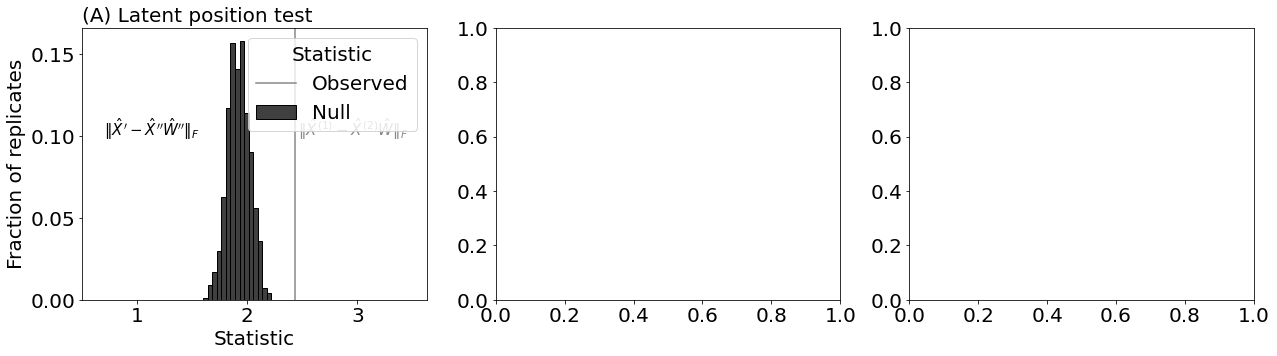

In [19]:
import seaborn as sns

fig, axs = plt.subplots(1, 3, figsize=(21, 5))
sns.histplot(null_norms, ax=axs[0], stat="probability", bins=15, color="black", label="Null")
axs[0].set_xlabel("Statistic")
axs[0].set_ylabel("Fraction of replicates")
axs[0].set_title("(A) Latent position test", loc="left", fontsize=20)
axs[0].axvline(x=observed_norm, color="#888888", label="Observed")
axs[0].legend(title="Statistic")
axs[0].annotate("$\\| \\hat X^{(1)} - \\hat X^{(2)}\\hat W\\|_F$", (observed_norm + .03, 0.1), color="#888888", fontsize=15)
axs[0].set_xlim([0.5, observed_norm + 1.2])
axs[0].set_yticks([0, 0.05, 0.1, 0.15])
axs[0].annotate("$\\| \\hat X^{\\prime} - \\hat X^{\\prime \\prime}\\hat W''\\|_F$", (0.7, 0.1), color="#000000", fontsize=15)

In [20]:
ncoins = 300  # the number of coins in each container

# the probabilities from container 1 landing on heads
# with a much larger variance
pi1 = np.random.beta(a=4, b=4, size=ncoins)

# the probabilities of container 2 landing on heads,
# with a much smaller variance
pi2 = np.random.beta(a=15, b=15, size=ncoins)

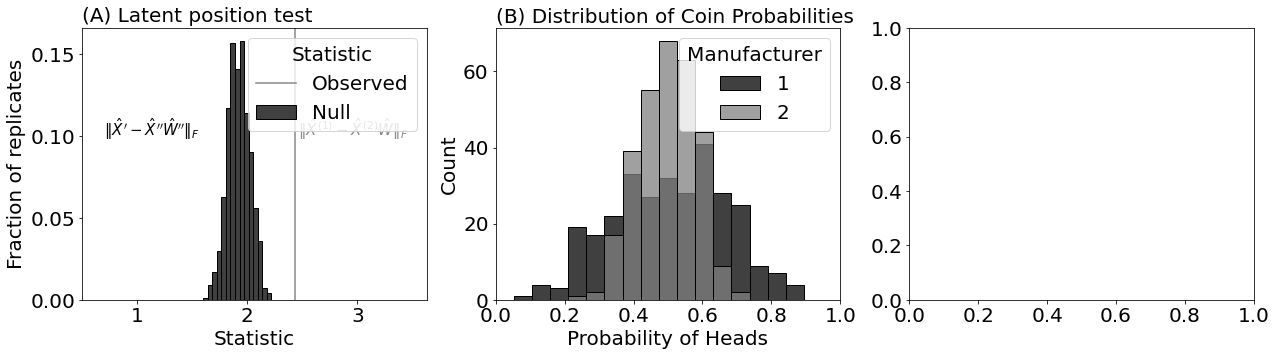

In [21]:
import pandas as pd

# Create common bins
bins = np.linspace(0, 1, 20)
# Plot histograms
sns.histplot(pi1, color="black", label="1", kde=False, bins=bins, ax=axs[1])
sns.histplot(pi2, color="grey", label="2", kde=False, bins=bins, ax=axs[1])

# Add legend
axs[1].legend(title="Manufacturer")
axs[1].set_xlim([0, 1])

# Add titles and labels
axs[1].set_title('(B) Distribution of Coin Probabilities', loc="left", fontsize=20)
axs[1].set_xlabel('Probability of Heads')

fig

In [22]:
from graspologic.inference import latent_distribution_test

nreps = 1000
approach = 'mgc'  # the strategy for the latent distribution test
ldt_dcorr = latent_distribution_test(A_human, A_alien, test=approach, metric="euclidean", n_bootstraps=nreps, workers=-1)
print("estimate of p-value: {:.5f}".format(ldt_dcorr.pvalue))

estimate of p-value: 0.00100


In [23]:
sns.histplot(ldt_dcorr.misc_dict["null_distribution"], color="black", ax=axs[2], stat="probability", label="Null")
axs[2].axvline(ldt_dcorr.stat, color="#888888", label="Observed")
axs[2].legend(title="Statistic")
axs[2].set_title("(C) Latent distribution test")
fig.tight_layout()

fname = "ts_ldt_ex"
if mode != "png":
    fig.savefig(f"Figures/{mode:s}/{fname:s}.{mode:s}")

fig.savefig(f"Figures/png/{fname:s}.png")

In [ ]:
fig